<div style="background-color:blue; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>Traffic Signs Classification 🛣️🤖</b></h1>
</div>

<div style="background-color:#000000; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <img src="https://media.tenor.com/NxZUCukvV5MAAAAd/traffic-cars.gif" alt="Animated GIF">
</div>

<div style="background-color:blue; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#ffffff;"><b>IMPORT DEPENDENCIES</b></h2>
</div>

In [1]:
import os
import cv2
import torch

import numpy               as np
import matplotlib.pyplot   as plt
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim

from PIL                     import Image
from torch.utils.data        import Dataset, DataLoader
from torchvision             import transforms, datasets
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


<div style="background-color:blue; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#ffffff;"><b>DATA PREPARETION</b></h2>
</div>

In [3]:
class GTSB(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir     = root_dir
        self.transform    = transform
        self.classes      = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images       = self.load_images()

    def load_images(self):
        images = []
        for class_dir in self.classes:
            class_path = os.path.join(self.root_dir, class_dir)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                images.append((img_path, self.class_to_idx[class_dir]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
dataset = GTSB(root_dir="/kaggle/input/gtsrb-german-traffic-sign/Train",transform=transform)

In [5]:
print(f"Number of Images {dataset.__len__()} , Number of Classes {len(dataset.classes)}")

Number of Images 39209 , Number of Classes 43


In [6]:
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [7]:
print(f"Number of Images In Train {train_dataset.__len__()} , Number of Images In Test {test_dataset.__len__()}")

Number of Images In Train 31367 , Number of Images In Test 7842


In [8]:
train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset ,batch_size=32, shuffle=True)

In [9]:
print("---------------------------------------------------------")
print(f"Number of batches in train_loader: {len(train_loader)}  ")
print(f"Number of batches in train_loader: {len(test_loader)}   ")
print("---------------------------------------------------------")
print(f"Number of Images in train_loader: {len(train_loader)*32}")
print(f"Number of Images in train_loader: {len(test_loader)*32} ")
print("---------------------------------------------------------")

---------------------------------------------------------
Number of batches in train_loader: 981  
Number of batches in train_loader: 246   
---------------------------------------------------------
Number of Images in train_loader: 31392
Number of Images in train_loader: 7872 
---------------------------------------------------------


<div style="background-color:blue; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#ffffff;"><b>MODEL ENGINEERING</b></h2>
</div>

In [10]:
class SCNN(nn.Module):
    def __init__(self):
        super(SCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128,43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
model     = SCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
train_losses = []
test_losses = []
accuracies = []

# 5. Training the model
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Print and store training loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')

    # 6. Evaluation
    model.eval()
    with torch.no_grad():
        running_test_loss = 0.0
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate test loss and accuracy
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        accuracy = correct / total
        accuracies.append(accuracy)

        # Print and store test loss and accuracy
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {100 * accuracy:.2f}%')

    model.train()

Epoch [1/20], Training Loss: 1.5442
Test Loss: 0.9255, Test Accuracy: 70.47%
Epoch [2/20], Training Loss: 0.6342
Test Loss: 0.5630, Test Accuracy: 81.37%
Epoch [3/20], Training Loss: 0.4113
Test Loss: 0.4266, Test Accuracy: 86.50%
Epoch [4/20], Training Loss: 0.3030
Test Loss: 0.3093, Test Accuracy: 89.80%
Epoch [5/20], Training Loss: 0.2413
Test Loss: 0.3090, Test Accuracy: 90.56%
Epoch [6/20], Training Loss: 0.2026
Test Loss: 0.2609, Test Accuracy: 91.85%
Epoch [7/20], Training Loss: 0.1780
Test Loss: 0.2298, Test Accuracy: 93.31%
Epoch [8/20], Training Loss: 0.1650
Test Loss: 0.2771, Test Accuracy: 91.99%
Epoch [9/20], Training Loss: 0.1403
Test Loss: 0.2791, Test Accuracy: 92.00%
Epoch [10/20], Training Loss: 0.1284
Test Loss: 0.2010, Test Accuracy: 94.50%
Epoch [11/20], Training Loss: 0.1141
Test Loss: 0.2581, Test Accuracy: 92.90%
Epoch [12/20], Training Loss: 0.1041
Test Loss: 0.1944, Test Accuracy: 94.67%
Epoch [13/20], Training Loss: 0.0986
Test Loss: 0.2116, Test Accuracy: 94

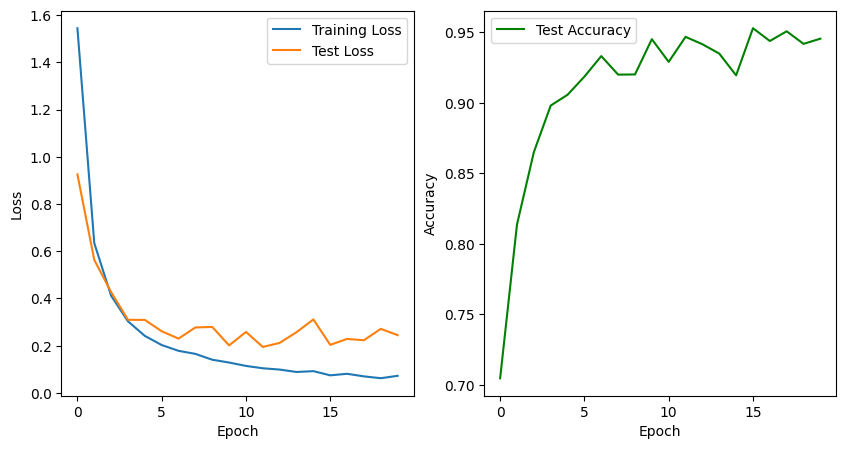

In [13]:
plt.figure(figsize=(10, 5))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()